# Projeto 3#
#### Antonio Fonseca, Daniel Pucciariello e José Bechara.####

## Tema:##
*Prever se um projeto do kickstarter irá ser bem sucedido ou não.*

Técnica: Classificador.

Objetivo secundário:

*Tentar estimar o valor a ser recebido baseado nas características de um projeto do kickstarter.*

Técnica: Regressão.

https://www.kaggle.com/kemical/kickstarter-projects


In [1]:
%matplotlib notebook
%reset -f


import pandas as pd
import numpy as np
from scipy.stats import norm, probplot
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

from datetime import datetime

%matplotlib inline

In [2]:
def dummify(data, column_name):
    """
        Converte a coluna column_name em dummies / one-hot e as adiciona ao dataframe
        retorna uma copia do  df original *sem* a coluna que foi dummified
    """
    df = data.copy()
    # Nota: se você for um econometrista, pode se interessar por usar a opção dropFirst = True na get_dummies
    df2 = pd.concat([df.drop(column_name, axis=1), pd.get_dummies(data[column_name], prefix=column_name)], axis=1)
    return df2


### Leitura dos dataframes:

In [3]:
data = pd.read_csv('ks-projects-201801.csv', parse_dates=['deadline', 'launched'])
#Retirando os projetos ainda não finalizados, pois nao servem como input:
data = data[data.state != "live"]

In [4]:
data.main_category.value_counts(True)

Film & Video    0.168288
Music           0.137383
Publishing      0.105291
Games           0.092970
Technology      0.085648
Design          0.079191
Art             0.074386
Food            0.064965
Fashion         0.060038
Theater         0.028926
Comics          0.028582
Photography     0.028550
Crafts          0.023235
Journalism      0.012568
Dance           0.009977
Name: main_category, dtype: float64

In [5]:
data.head(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [6]:
print("Tamanho do dataframe:")
len(data)

Tamanho do dataframe:


375862

In [7]:
# #para uso em cada tipo de modelo, marcamos as colunas com variaveis qualitativa
# data.category = data.category.astype('category')
# data.main_category = data.main_category.astype('category')
# data.state = data.state.astype('category')
# data.country = data.country.astype('category')

### Porcentagem de sucesso nos projetos:

In [8]:
#checando a quantidade relativa de cada output
data.state.value_counts(True)*100

failed        52.604147
successful    35.639676
canceled      10.317351
undefined      0.947688
suspended      0.491138
Name: state, dtype: float64

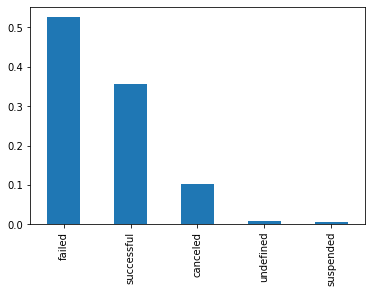

In [9]:
#para visualizar graficamente
data.state.value_counts(True).plot.bar();

### Simplificando o estado dos projetos para "failed" e "successful"

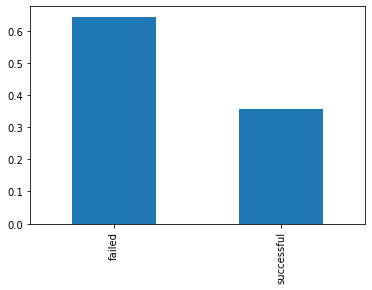

In [10]:
data_boolean = data.replace("canceled", "failed").replace("undefined", "failed").replace("suspended", "failed")
#criação de dataframe cujos estados dos projetos eram "failed" ou "successful"
data_boolean.state.value_counts(True).plot.bar();

In [11]:
data_boolean.state.value_counts(True)*100

failed        64.360324
successful    35.639676
Name: state, dtype: float64

### "Dummyficando" as variáveis qualitativas:

In [12]:
#a funcao dummyfy separa uma variavel categorica em varias colunas (cada umareferentea uma categoria) marcadas or 0 e 1 
#permitindo o tratamento como variavel quantitativa
data_dummified = dummify(data_boolean, "state")

data_dummified.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'backers', 'country', 'usd pledged',
       'usd_pledged_real', 'usd_goal_real', 'state_failed',
       'state_successful'],
      dtype='object')

In [13]:
Y = data_dummified.loc[:,[ "state_failed","state_successful"]]
Y1= Y.state_successful == 1 
X1 = data_dummified.loc[:,['goal']]

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.1, random_state=112)

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((338275, 1), (338275,), (37587, 1), (37587,))

# Qualitativas:

## Regressão Logística:

### Objetivo de prever se o projeto terá sucesso ou não.

In [16]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', multi_class='auto',max_iter=200)

In [17]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
y_pred = model.predict(X_test)

# Calcula acurácia.
acc = accuracy_score(y_test, y_pred)

print('Acurácia: {}'.format(acc))

Acurácia: 0.6482826509165402


___

## Random Forest

### Objetivo de prever se o projeto terá sucesso ou não.

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
rdm_forest = RandomForestClassifier(n_estimators=10, random_state=112)
rdm_forest = rdm_forest.fit(X_train,y_train)
rdm_forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=112,
                       verbose=0, warm_start=False)

In [21]:
y_pred = rdm_forest.predict(X_test)

# Calcula acurácia.
acc = accuracy_score(y_test, y_pred)

print('Acurácia: {}'.format(acc))

Acurácia: 0.6508633304067896


____

# Quantitativas

## Regressão Linear:

### Objetivo de prever o quanto o projeto irá arrecadar.

In [22]:
def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

def rms(y, y_pred):
    '''
    Retorna o RMS
    
    y --> valores reais
    y_pred --> valores preditos
    '''
    return (sum((y-y_pred)**2)*1/len(y))**0.5

def acuracia(limite, y_pred, y_test):
    total = 0
    acertos = 0
    erros = 0
    lista = []
    for e,i in zip(y_pred, y_test):
        total+=1
        maximo = i + limite*i 
        minimo = i - limite*i
        if e<=maximo and e>=minimo:
            lista.append(True)
            acertos +=1
        else:
            lista.append(False)
            erros+=1
    acc = acertos/total
    erro = erros/total
    
    return [acc, erro]

In [23]:
data_regressao_pledge = data_dummified.loc[:,['goal', 'state_successful', "usd_pledged_real", "usd_goal_real"]]
data_regressao_pledge.head()

,goal,state_successful,usd_pledged_real,usd_goal_real
0,1000.0,0,0.0,1533.95
1,30000.0,0,2421.0,30000.00
2,45000.0,0,220.0,45000.00
3,5000.0,0,1.0,5000.00
4,19500.0,0,1283.0,19500.00


#### Dividindo em treinamento e teste:

In [24]:
y2 = data_regressao_pledge.usd_pledged_real
X_train2, X_test2, y_train2, y_test2 = train_test_split(data_regressao_pledge, y2, test_size=0.1, random_state=112)

In [25]:
X_train2=X_train2.drop(columns=['usd_pledged_real', "state_successful"]) # removendo coluna de dinheiro do dataframe de treinamento

In [26]:
X_test2=X_test2.drop(columns=['usd_pledged_real', "state_successful"]) # removendo coluna de dinheiro do dataframe de treinamento

In [27]:
model = regress(X_train2,y_train2)
model.summary() 

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       usd_pledged_real   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.871
Date:                Thu, 21 Nov 2019   Prob (F-statistic):            0.00282
Time:                        14:25:40   Log-Likelihood:            -4.3384e+06
No. Observations:              338275   AIC:                         8.677e+06
Df Residuals:                  338272   BIC:                         8.677e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          9029.4717    154.678     58.376      0.000    8726.307    9332.636
goal          -7.887e-05      0.000     -0.193      0.847      -0.001       0.001
usd_goal_real     0.0005      0.000      1.321      0.187      -0.000       0.001
==============================================================================
Omnibus:                  1264188.100   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    2113426436556.797
Skew:                          82.558   Prob(JB):                         0.00
Kurtosis:                   12247.040   Cond. No.                     1.57e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
x_vc=(sm.add_constant(X_test2))
y_pred2=model.predict(x_vc) 
from sklearn.metrics import r2_score

print("O valor de RMS do modelo utilizando regressão linear é:",r2_score(y_test2, y_pred2, multioutput="variance_weighted"))

O valor de RMS do modelo utilizando regressão linear é: 5.614486454308399e-06


#### Função para medir a acurácia com tolerância de 35%

In [29]:
acc = acuracia(0.35, y_pred2, y_test2)
print("Porcentagem de acurácia na previsão de pledge quando a margem de erro é de 35% é",acc[0]*100,"%")
print("Porcentagem de erro na previsão de pledge quando a margem de erro é de 35% é",acc[1]*100,"%")

Porcentagem de acurácia na previsão de pledge quando a margem de erro é de 35% é 8.103865698246734 %
Porcentagem de erro na previsão de pledge quando a margem de erro é de 35% é 91.89613430175326 %


___

## Random Forest regressor

### Objetivo de prever o quanto o projeto irá arrecadar.

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [31]:
regr_rd = RandomForestRegressor(max_depth=4, random_state=113, n_estimators=100) 
regr_rd.fit(X_train2, y_train2)  

y_pred3=regr_rd.predict(X_test2)

In [32]:
from sklearn.metrics import r2_score

print("O valor de RMS do modelo utilizando regressão linear é:",r2_score(y_test2, y_pred3, multioutput="variance_weighted"))

O valor de RMS do modelo utilizando regressão linear é: 0.016432587235676532


#### Função para medir a acurácia com tolerância de 35%

In [33]:
acc = acuracia(0.35, y_pred3, y_test2)
print("Porcentagem de acurácia na previsão de pledge quando a margem de erro é de 35% é",acc[0]*100,"%")
print("Porcentagem de erro na previsão de pledge quando a margem de erro é de 35% é",acc[1]*100,"%")

Porcentagem de acurácia na previsão de pledge quando a margem de erro é de 35% é 17.46082422114029 %
Porcentagem de erro na previsão de pledge quando a margem de erro é de 35% é 82.53917577885971 %


___

# Melhorando o modelo:

### 'Dummyficando' mais variaveis para o modelo: 

In [34]:
data_dummified = dummify(data_boolean, "main_category")
data_dummified = dummify(data_dummified, "state")
data_dummified.columns

Index(['ID', 'name', 'category', 'currency', 'deadline', 'goal', 'launched',
       'pledged', 'backers', 'country', 'usd pledged', 'usd_pledged_real',
       'usd_goal_real', 'main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'state_failed', 'state_successful'],
      dtype='object')

In [35]:
#aplicando a funcao dummify criada acima para criar um novo frame
data_dummified = dummify(data, "main_category")
data_dummified = dummify(data_dummified, "state")

#criação de um dataframe com as variaveis quantitativas (incluindo as provenientes de dummyficação)
quantitativas = data_dummified.loc[:,['goal', 'state_successful', 'main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater' ]]
quantitativas.head(5)

,goal,state_successful,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,1000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,30000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,45000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,5000.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,19500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Calculando o tempo de duração das campanhas:

In [36]:
def calculo_dias(date1,date2):
    """
        Função que calculo a quantidade de dias que um projeto ficou ativo.
    """
    date_format = "%Y-%m-%d %H:%M:%S"
    a = datetime.strptime(date1, date_format)
    b = datetime.strptime(date2, date_format)
    delta= a-b
    return delta.days


In [37]:
#criação de uma lista com os valores de tempo de duracao da campanha em dias.
delta_t =[]
for e,i in zip(data.deadline, data.launched):
    e = str(e)
    i = str(i)
    a = calculo_dias(e,i)
    delta_t.append(a)

In [38]:
#criação de um dataframe semelhante ao criado anteriormente, porém com o delta_t dos projetos.
data_delta_t=quantitativas
data_delta_t["deltat (days)"]=delta_t
data_delta_t.head()

,goal,state_successful,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,deltat (days)
0,1000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,58
1,30000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,59
2,45000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,44
3,5000.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,29
4,19500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,55


#### Dividindo em treinamento e teste:

In [39]:
y = quantitativas.state_successful == 1

In [40]:
X_train_melhorado_quali, X_test_melhorado_quali, y_train_melhorado_quali, y_test_melhorado_quali = train_test_split(data_delta_t, y, test_size=0.1, random_state=112)

In [41]:
X_train_melhorado_quali=X_train_melhorado_quali.drop(columns=['state_successful']) # removendo coluna de estado do dataframe de treinamento
X_test_melhorado_quali=X_test_melhorado_quali.drop(columns=['state_successful'])# removendo coluna de estado do dataframe de teste 

## Regressão Logística:

### Objetivo de prever se o projeto terá sucesso ou não.

In [42]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', multi_class='auto',max_iter=200)

In [43]:
model.fit(X_train_melhorado_quali, y_train_melhorado_quali)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
y_pred_melhorado_quali = model.predict(X_test_melhorado_quali)

# Calcula acurácia.
acc = accuracy_score(y_test_melhorado_quali, y_pred_melhorado_quali)

print('Acurácia: {}'.format(acc))

Acurácia: 0.6482826509165402


# Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
rdm_forest = RandomForestClassifier(n_estimators=10, random_state=112)
rdm_forest = rdm_forest.fit(X_train_melhorado_quali,y_train_melhorado_quali)
rdm_forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=112,
                       verbose=0, warm_start=False)

In [47]:
y_pred_melhorado_quali = rdm_forest.predict(X_test_melhorado_quali)

# Calcula acurácia.
acc = accuracy_score(y_test_melhorado_quali, y_pred_melhorado_quali)

print('Acurácia: {}'.format(acc))

Acurácia: 0.6596961715486738


#### Escolhendo os melhores parametros para o Random Forest Classifier

In [48]:
# from sklearn.ensemble import RandomForestClassifier
# rdm_forest = RandomForestClassifier(random_state=112)

# space_parameter = {
#     "n_estimators" : [50, 100], "criterion":["entropy", "gini"]
# } 

# from sklearn.model_selection import GridSearchCV

# rdm = GridSearchCV(rdm_forest, space_parameter, verbose = True, return_train_score=True)
# rdm.fit(X_train,y_train)

In [49]:
# print("Os melhores parametros são:",rdm.best_params_)

In [50]:
rdm_forest_2 = RandomForestClassifier(n_estimators=100, random_state=112, criterion= 'gini')
rdm_forest_2 = rdm_forest_2.fit(X_train_melhorado_quali,y_train_melhorado_quali)

In [51]:
y_pred_forest2 = rdm_forest_2.predict(X_test_melhorado_quali)

# Calcula acurácia.
acc = accuracy_score(y_test_melhorado_quali, y_pred_forest2)

print('Acurácia: {}'.format(acc))

Acurácia: 0.6619309867773432


___

## Regressão Linear:

In [52]:
data_regressao_pledge = data_dummified.loc[:,['goal', 'state_successful', 'main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', "usd_pledged_real", "usd_goal_real"]]
data_regressao_pledge.head()

,goal,state_successful,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,usd_pledged_real,usd_goal_real
0,1000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,1533.95
1,30000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2421.0,30000.00
2,45000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,220.0,45000.00
3,5000.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0,5000.00
4,19500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1283.0,19500.00


In [53]:
y2 = data_regressao_pledge.usd_pledged_real
data_regressao_pledge["delta t"]=delta_t
X_train_melhorado_quanti, X_test_melhorado_quanti, y_train_melhorado_quanti, y_test_melhorado_quanti = train_test_split(data_regressao_pledge, y2, test_size=0.1, random_state=112)

In [54]:
X_test_melhorado_quanti=X_test_melhorado_quanti.drop(columns=['usd_pledged_real', "state_successful"]) # removendo coluna de dinheiro do dataframe de treinamento
X_train_melhorado_quanti=X_train_melhorado_quanti.drop(columns=['usd_pledged_real', "state_successful"]) # removendo coluna de dinheiro do dataframe de treinamento

In [55]:
model = regress(X_train_melhorado_quanti,y_train_melhorado_quanti)
model.summary() 

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       usd_pledged_real   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     151.6
Date:                Thu, 21 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:26:45   Log-Likelihood:            -4.3372e+06
No. Observations:              338275   AIC:                         8.674e+06
Df Residuals:                  338257   BIC:                         8.675e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       7197.0784    211.313     34.059      0.000    6782.911    7611.246
goal                          -0.0003      0.000     -0.697      0.486      -0.001       0.001
main_category_Art          -4032.3782    564.742     -7.140      0.000   -5139.256   -2925.500
main_category_Comics        -480.4577    872.516     -0.551      0.582   -2190.563    1229.648
main_category_Crafts       -5641.7619    964.362     -5.850      0.000   -7531.884   -3751.640
main_category_Dance        -3710.9949   1455.416     -2.550      0.011   -6563.569    -858.421
main_category_Design        1.694e+04    548.701     30.872      0.000    1.59e+04     1.8e+04
main_category_Fashion      -1409.1162    620.868     -2.270      0.023   -2625.999    -192.233
main_category_Film & Video -1083.2606    404.246     -2.680      0.007   -1875.571    -290.950
main_category_Food         -2262.2413    600.847     -3.765      0.000   -3439.885   -1084.598
main_category_Games         1.384e+04    512.857     26.994      0.000    1.28e+04    1.48e+04
main_category_Journalism   -4696.0109   1306.356     -3.595      0.000   -7256.431   -2135.590
main_category_Music        -3367.9611    436.701     -7.712      0.000   -4223.883   -2512.039
main_category_Photography  -3670.9862    875.459     -4.193      0.000   -5386.861   -1955.111
main_category_Publishing   -3926.8342    487.456     -8.056      0.000   -4882.235   -2971.434
main_category_Technology    1.389e+04    530.330     26.187      0.000    1.28e+04    1.49e+04
main_category_Theater      -3192.3330    870.491     -3.667      0.000   -4898.470   -1486.195
usd_goal_real                  0.0007      0.000      1.631      0.103      -0.000       0.001
delta t                        1.0523      2.213      0.476      0.634      -3.285       5.389
==============================================================================
Omnibus:                  1266803.741   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    2160412393104.332
Skew:                          83.084   Prob(JB):                         0.00
Kurtosis:                   12382.408   Cond. No.                     2.97e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.47e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [56]:
x_vc=(sm.add_constant(X_test_melhorado_quanti))
y_pred_linear=model.predict(x_vc)

#### Função para medir a acurácia com tolerância de 35%

In [57]:
acc = acuracia(0.35, y_pred_linear, y_test_melhorado_quanti)
print("Porcentagem de acurácia na previsão de pledge quando a margem de erro é de 35% é",acc[0]*100,"%")
print("Porcentagem de erro na previsão de pledge quando a margem de erro é de 35% é",acc[1]*100,"%")

Porcentagem de acurácia na previsão de pledge quando a margem de erro é de 35% é 9.894378375502168 %
Porcentagem de erro na previsão de pledge quando a margem de erro é de 35% é 90.10562162449783 %


In [58]:
from sklearn.metrics import r2_score

print("O valor de RMS do modelo utilizando regressão linear",r2_score(y_test_melhorado_quanti, y_pred_linear, multioutput="variance_weighted"))

O valor de RMS do modelo utilizando regressão linear 0.006595711827519168


## Random Forest regressor

In [59]:
regr_rd = RandomForestRegressor(max_depth=4, random_state=113, n_estimators=100) 
regr_rd.fit(X_train_melhorado_quanti, y_train_melhorado_quanti)  

y_pred_melhorado_reg=regr_rd.predict(X_test_melhorado_quanti)

In [60]:
from sklearn.metrics import r2_score
print("O valor de RMS do modelo utilizando regressão linear é:",r2_score(y_test_melhorado_quanti, y_pred_melhorado_reg, multioutput="variance_weighted"))

O valor de RMS do modelo utilizando regressão linear é: 0.031000437373576162


#### Função para medir a acurácia com tolerância de 35%

In [61]:
acc = acuracia(0.35, y_pred_melhorado_reg, y_test_melhorado_quanti)
print("Porcentagem de acurácia na previsão de pledge quando a margem de erro é de 35% é",acc[0]*100,"%")
print("Porcentagem de erro na previsão de pledge quando a margem de erro é de 35% é",acc[1]*100,"%")

Porcentagem de acurácia na previsão de pledge quando a margem de erro é de 35% é 15.893793066751801 %
Porcentagem de erro na previsão de pledge quando a margem de erro é de 35% é 84.10620693324819 %
